# IS-RSA 
1. Create separate matrices for neural and behavioral data.
- The neural matrix should have dimensions (trials/conditions, neural features).
- The behavioral matrix should have dimensions (trials/conditions, behavioral features).

2. Time series 별로 비교해 볼 수 있다. 

3. 현재는 두 인코딩 간을 비교할 수 없는 모델인데 이건 교수님과 좀더 상의를 해봐야할 것 같다.

In [5]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img_on_surf, view_img
from bids import BIDSLayout, BIDSValidator

import nibabel as nib

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [66]:
# dir for neural 
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
May_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

# directory for behav
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

In [65]:
#Subject check 
sub_sm = np.arange(1,34)
sub_sm_exclude = [8]
subjects = np.delete(sub_sm, sub_sm_exclude)
#print(subject)
print(subjects)

[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33]


In [244]:
# load story sequence 
import scipy.io as sio

all_story = {}
# Load May Data
for sub in subjects:
    #print(sub)
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', 'fMRI_May', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,4):
        temp = mat['subj'][0][0][7][0][i][0]
        if temp == 'Blind Date':
            temp = 'BlindDate'
        elif temp == 'Runningman':
            temp = 'RunningMan'
        elif temp == 'Way To School':
            temp = 'WayToSchool'
        elif temp == 'Business Lunch':
            temp = 'BusinessLunch'
        elif temp == 'neighbors':
            temp = 'Neighbors'
        story = np.append(story, temp)
    #all_story[str(int(sub)+8)] = story
    all_story[sub] = story
#Fix story sequence
story_sequece = all_story[1]
story_sequece

array(['RunningMan', 'BlindDate', 'Dream', 'Neighbors'], dtype='<U32')

In [69]:
# directory for behav
base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'
ec_counting = '/mnt/c/Users/since/Dropbox/jany/'

col_sm = np.arange(2,35)
col_sm_exclude = [8,25] # sub 10, 26 excluded
cols = np.delete(col_sm, col_sm_exclude) 
#print(cols)
#print(len(cols))

run_ec= pd.read_excel(os.path.join(ec_counting,'Event_counting.xlsx'), sheet_name = 'Run_2', usecols = cols)
dre_ec= pd.read_excel(os.path.join(ec_counting,'Event_counting.xlsx'), sheet_name = 'Dre_2', usecols = cols)
nei_ec= pd.read_excel(os.path.join(ec_counting,'Event_counting.xlsx'), sheet_name = 'Nei_2', usecols = cols)
bli_ec= pd.read_excel(os.path.join(ec_counting,'Event_counting.xlsx'), sheet_name = 'Bli_2', usecols = cols)

#chage NAN to 0 
run_ec = run_ec.fillna(0)
dre_ec = dre_ec.fillna(0)
nei_ec = nei_ec.fillna(0)
bli_ec = bli_ec.fillna(0)

[ 2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 28 29 30 31 32 33 34]
31


In [70]:
# Define Event Counting vectors 
vis_run_ec = run_ec[0:13].reset_index(drop=True)
aud_run_ec = run_ec[13:26].reset_index(drop=True)

vis_dre_ec = dre_ec[0:10].reset_index(drop=True)
aud_dre_ec = dre_ec[10:20].reset_index(drop=True)

vis_nei_ec = nei_ec[0:16].reset_index(drop=True)
aud_nei_ec = nei_ec[16:32].reset_index(drop=True)

vis_bli_ec = bli_ec[0:10].reset_index(drop=True)
aud_bli_ec = bli_ec[10:20].reset_index(drop=True)

# Define Updating vectors 
update_run_ed = run_ec[26:39].reset_index(drop=True)
update_dre_ec = dre_ec[20:30].reset_index(drop=True)
update_nei_ec = nei_ec[32:48].reset_index(drop=True)
update_bli_ec = bli_ec[20:30].reset_index(drop=True)

In [111]:
visual_stroy_ec = {'run' : vis_run_ec, 'dream': vis_dre_ec, 'nei': vis_nei_ec, 'bli': vis_bli_ec}
audio_stroy_ec = {'run' : aud_run_ec, 'dream': aud_dre_ec, 'nei': aud_nei_ec, 'bli': aud_bli_ec}
update_stroy_ec = {'run' : update_run_ed, 'dream': update_dre_ec, 'nei': update_nei_ec, 'bli': update_bli_ec}

In [226]:
col = update_stroy_ec['run'].columns
len(col)

31

# 1. Make Behav similarity matrix 

In [414]:
#make behavior predictors as (timeseries * features [reuse, details, events, delete])

import re

eventTime = {'run':[11,24,26,28,34,44,58,59,65,67,69,99,107], 'dream':[11, 16, 18, 22, 35, 51, 71, 76, 88, 100], 'nei': [11,14,19, 22,25,28,31,34,38,42,62,72,88,89,94,110], 'bli': [11,13,22,24,28,40,43,56,60,104]}
story_timeseries = {}
for story in ['run', 'dream', 'nei', 'bli']:
    sub_timeseries = {} 
    for col in update_stroy_ec[story].columns:
        
        event_time = eventTime[story]
        
        timecourse_values = np.tile([0,0,0,0], (event_time[0]-1, 1)) # for countdown
        
        for i in range(len(event_time)) : # start from 0~12 
            update_score = update_stroy_ec[story][col][i]
            if story == 'dream':
                end_time = 110 # 10 / 100/ 6 
            else: 
                end_time = 120 # 10/ 110/ 6

            if update_score == 0: # reuse
                score_array = np.array([1, 0, 0, 0])
            elif update_score == 0.5: # detail addition
                score_array = np.array([0, 1, 0, 0])
            elif update_score == 1: # event addition
                score_array = np.array([0, 0, 1, 0])
            elif update_score == - 1:
                score_array = np.array([0, 0, 0, 1])

            if i == len(event_time) - 1:
                duration = end_time - event_time[i] + 1
                event_timeseries = np.tile(score_array, (duration, 1))
            else: 
                duration = event_time[i+1] - event_time[i]
                event_timeseries = np.tile(score_array, (duration, 1))   
                
            timecourse_values = np.concatenate([timecourse_values, event_timeseries], axis = 0)
                
        #timecourse_values = np.concatenate([timecourse_values, dummy], axis = 0)
            

                             
        # Use regular expression to split alphabetic and numeric parts
        match = re.match(r"([a-zA-Z]+)([0-9]+)", col)

        if match:
            alphabetic_part = match.group(1)
            numeric_part = match.group(2)

        sub_timeseries[int(numeric_part)] = timecourse_values
    story_timeseries[story] =sub_timeseries

In [415]:
story_timeseries['run'][2].shape

(120, 4)

In [109]:
# a. Correlation matrix between for each subject
import numpy as np    
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns

dinstance_for_story = {} 
for story in ['run', 'dream', 'nei', 'bli']:
    vis_col_names = visual_stroy_ec[story].columns
    col_len = len(visual_stroy_ec[story].index)
    
    distance_map = {}
    for col in vis_col_names:  
        vis_ec = np.array(visual_stroy_ec[story][col]).reshape((col_len, 1))
        aud_ec = np.array(visual_stroy_ec[story][col]).reshape((col_len, 1)) 
        # calculate condensed distance matrix by wrapping the hamming distance function
        distance_map[int(col[2])] = distance_matrix(vis_ec, aud_ec, p = 2)
        
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(distance_map[int(col[2])], cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
        # plt.title('Distance Matrix Heatmap')
        # plt.show()
        
        # average between subjects ?
    dinstance_for_story[story] = distance_map
        

In [73]:
# b. cole's logics

# 2. Make brain similarity matrix

## Load brain datas

In [8]:
# Data Load & Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D

sub_story_timeseries = {}
for sub in subjects:
    story = {} 
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    #print(sequence)
    cond = 'Dream'+str(int(sequence)+1)
    #print(cond)
    denoised_dir = os.path.join(May_dir, 'denoised', 'denoised_2023')
    if sub < 10:
        data = glob.glob(os.path.join(denoised_dir,'Averaged_ROI', f'sub-0{sub}_task-encoding_run-1_Average_ROI_n50.csv'))   
        data2 = glob.glob(os.path.join(denoised_dir,'Averaged_ROI', f'sub-0{sub}_task-encoding_run-2_Average_ROI_n50.csv')) 
    else: 
        data = glob.glob(os.path.join(denoised_dir,'Averaged_ROI', f'sub-{sub}_task-encoding_run-1_Average_ROI_n50.csv'))   
        data2 = glob.glob(os.path.join(denoised_dir,'Averaged_ROI', f'sub-{sub}_task-encoding_run-2_Average_ROI_n50.csv'))
    
    for i in np.arange(0,4):
        storyName = ['run', 'blind', 'dream', 'nei']
        story[storyName[i]] = {'visual' : data[onset[cond][i]:offset[cond][i]], 'audio' : data2[onset[cond][i]:offset[cond][i]]}
    
    sub_story_timeseries[sub] = story

In [229]:
# Data Load & Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D

func_imgs, n_trs = {}, {}
for sub in subjects:

    denoised_dir = os.path.join(May_dir, 'denoised', 'denoised_2023')
    n_tr, func_img = {}, {}
    for run in [1,2]: 
        if sub < 10:
            data_dir = glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-{run}_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'))[0]   
        else: 
            data_dir = glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-{run}_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'))[0] 
        func_img[run] = nib.load(data_dir)
        n_tr[run] = func_img[run].shape[3]
    func_imgs[sub] = func_img
    n_trs[sub] = n_tr  


## Load beta maps with GLM 

In [71]:
# 1. 참가자 변수 - 절편 값 
# 2. 참가자 이야기 순서 
sub_sequence = all_story[sub]
# 3. 이야기 변수 - onset, offset 으로 설정 
sequence = np.where(sub_sequence=='Dream')[0][0]
cond = 'Dream'+str(int(sequence)+1)

onset = {'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 

# 4. 사건 변수 - 저번에 정리한 걸로
story_EB_visual = {'run':[18,38,48,88], 'dream':[6,18,78], 'nei':[64,85], 'blind':[50,58,93]}
story_EB_audio = {'run':[16, 48,68,88,108], 'dream':[8,18,78], 'nei':[12,32,44,62,84], 'blind':[25,77,95]}

# 5. 언급 유무 변수 
# Define Event Counting vectors 
vis_run_ec = run_ec[0:13].reset_index(drop=True)
aud_run_ec = run_ec[13:26].reset_index(drop=True)

vis_dre_ec = dre_ec[0:10].reset_index(drop=True)
aud_dre_ec = dre_ec[10:20].reset_index(drop=True)

vis_nei_ec = nei_ec[0:16].reset_index(drop=True)
aud_nei_ec = nei_ec[16:32].reset_index(drop=True)

vis_bli_ec = bli_ec[0:10].reset_index(drop=True)
aud_bli_ec = bli_ec[10:20].reset_index(drop=True)

# Define Updating vectors 
update_run_ed = run_ec[26:39].reset_index(drop=True)
update_dre_ec = dre_ec[20:30].reset_index(drop=True)
update_nei_ec = nei_ec[32:48].reset_index(drop=True)
update_bli_ec = bli_ec[20:30].reset_index(drop=True)

In [400]:


sub_recall_timeseries = {}
for sub in subjects:
    storyName = {'RunningMan':'run','BlindDate':'bli', 'Dream':'dre', 'Neighbors':'nei'}
    for num in range(0,4):
    resue = story_timeseries[storyName[all_story[sub][0]]][sub]
    recall2 = story_timeseries[storyName[all_story[sub][1]]][sub]
    recall3 = story_timeseries[storyName[all_story[sub][2]]][sub]
    recall4 = story_timeseries[storyName[all_story[sub][3]]][sub]
        
    sub_recall_timeseries[sub] = np.vstack([[intercept], [recall1], [recall2], [recall3], [recall4],])


In [405]:
eventTime = {'run':[11,24,26,28,34,44,58,59,65,67,69,99,107], 'dream':[11, 16, 18, 22, 35, 51, 71, 76, 88, 100], 'nei': [11,14,19, 22,25,28,31,34,38,42,62,72,88,89,94,110], 'bli': [11,13,22,24,28,40,43,56,60,104]}

n_tr = 477 
sub_story_timeseries = {}
for sub in subjects:
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    storyName = all_story[sub]
    
    story1 = np.zeros(n_tr)
    story1[onset[cond][0]:offset[cond][0]] =  1 
    story2 = np.zeros(n_tr)
    story2[onset[cond][1]:offset[cond][1]] =  1 
    story3 = np.zeros(n_tr)
    story3[onset[cond][2]:offset[cond][2]] =  1 
    story4 = np.zeros(n_tr)
    story4[onset[cond][3]:offset[cond][3]] =  1 
    
    intercept = np.ones(n_tr)
    
    sub_story_timeseries[sub] = (np.vstack([[intercept], [story1], [story2], [story3], [story4],])).T


In [404]:
sub_story_timeseries[sub].shape

(477, 5)

In [38]:
from nltools.data import Brain_Data, Design_Matrix
TR = 1
intercept = np.ones(n_tr)
x1 = (np.vstack([[countdown], [YesStimulus], [story1], [story2], [story3], [story4], [story5]])).T
print(x1.shape)
dm1 = Design_Matrix(x1, sampling_freq = 1./TR, columns = ['countdown', 'YesStimulus', 'story1', 'story2', 'story3', 'story4', 'story5'])

9

## Intra-subject correlation in brain 

In [239]:
import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

In [261]:
May_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

In [358]:
#Subject check 
sub_sm = np.arange(1,34)
sub_sm_exclude = [0,8,25]
subjects = np.delete(sub_sm, sub_sm_exclude)
#print(subject)
print(subjects)

[ 2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27
 28 29 30 31 32 33]


In [316]:
# Data Load & Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D


sub_story_timeseries = {}
for sub in subjects:
    story = {} 
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    #print(sequence)
    cond = 'Dream'+str(int(sequence)+1)
    #print(cond)
    denoised_dir = os.path.join(May_dir, 'denoised', 'denoised_2023')
    if sub < 10:
        data = pd.read_csv(os.path.join(denoised_dir,'Averaged_ROI', f'sub-0{sub}_task-encoding_run-1_Average_ROI_n50.csv'))   
        data2 = pd.read_csv(os.path.join(denoised_dir,'Averaged_ROI', f'sub-0{sub}_task-encoding_run-2_Average_ROI_n50.csv')) 
    else: 
        data = pd.read_csv(os.path.join(denoised_dir,'Averaged_ROI', f'sub-{sub}_task-encoding_run-1_Average_ROI_n50.csv'))   
        data2 = pd.read_csv(os.path.join(denoised_dir,'Averaged_ROI', f'sub-{sub}_task-encoding_run-2_Average_ROI_n50.csv'))
    
    
    for i in np.arange(0,4):
    #print(cond)
        storyName = {'RunningMan':'run','BlindDate':'bli', 'Dream':'dre', 'Neighbors':'nei'}
        story[storyName[all_story[sub][i]]] = {'visual' : data[onset[cond][i]:offset[cond][i]], 'audio' : data2[onset[cond][i]:offset[cond][i]]}

    sub_story_timeseries[int(sub)] = story

In [319]:
os.path.join(denoised_dir,'Averaged_ROI', f'sub-{sub}_task-encoding_run-1_Average_ROI_n50.csv')

'/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/Averaged_ROI/sub-33_task-encoding_run-1_Average_ROI_n50.csv'

In [353]:
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [359]:
data = {} 
for sub in subjects:
    print(sub)
    run_data = {} 
    for run in range(1,3): # run = 1,2
        #print(run) 
        if sub < 10:
            run_data[run] = pd.read_csv(os.path.join(denoised_dir,'Averaged_ROI', f'sub-0{sub}_task-encoding_run-{run}_Average_ROI_n50.csv'))
        else:
            run_data[run] = pd.read_csv(os.path.join(denoised_dir,'Averaged_ROI', f'sub-{sub}_task-encoding_run-{run}_Average_ROI_n50.csv'))
        print(run_data[run].shape)
    sub_data = np.stack([run_data[1].to_numpy(), run_data[2].to_numpy()], axis = 0)
    data[sub] = np.array(sub_data)   # (2,117, 50) 
        
    
    

# data = []
# for subj in subj_list:
#     sub_data = []
#     for run in range(1,4):
#         sub_data.append(pd.read_csv(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')))
#     sub_data = pd.concat(sub_data)
#     data.append(sub_data.values)
# data = np.array(data)


2
(477, 50)
(477, 50)
3
(477, 50)
(477, 50)
4
(477, 50)
(477, 50)
5
(477, 50)
(477, 50)
6
(477, 50)
(477, 50)
7
(477, 50)
(477, 50)
8
(477, 50)
(477, 50)
10
(477, 50)
(477, 50)
11
(477, 50)
(477, 50)
12
(477, 50)
(477, 50)
13
(477, 50)
(477, 50)
14
(477, 50)
(477, 50)
15
(477, 50)
(477, 50)
16
(477, 50)
(477, 50)
17
(477, 50)
(477, 50)
18
(477, 50)
(477, 50)
19
(477, 50)
(477, 50)
20
(477, 50)
(477, 50)
21
(477, 50)
(477, 50)
22
(477, 50)
(477, 50)
23
(477, 50)
(477, 50)
24
(477, 50)
(477, 50)
25
(477, 50)
(477, 50)
27
(477, 50)
(477, 50)
28
(477, 50)
(477, 50)
29
(477, 50)
(477, 50)
30
(477, 50)
(477, 50)
31
(477, 50)
(477, 50)
32
(477, 50)
(477, 50)
33
(477, 50)
(477, 50)


In [362]:
print(data[2].shape)
n_subs, n_ts, n_nodes = data[2].shape

(2, 477, 50)


In [376]:
sub_similarity_matrices = {}
for sub in subjects:
    similarity_matrices = []
    for node in range(n_nodes):
        for n_t in range(n_ts):
            similarity_matrices.append(Adjacency(1 - pairwise_distances(data[sub][:, n_t, node], metric='correlation'), matrix_type='similarity'))
    sub_similarity_matrices[sub] =  Adjacency(similarity_matrices)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.7269192 -1.7704142].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [372]:
sub_similarity_matrices[sub].shape

<bound method Adjacency.shape of nltools.data.adjacency.Adjacency(shape=(50, 1), square_shape=(2, 2), Y=0, is_symmetric=True,matrix_type=similarity)>

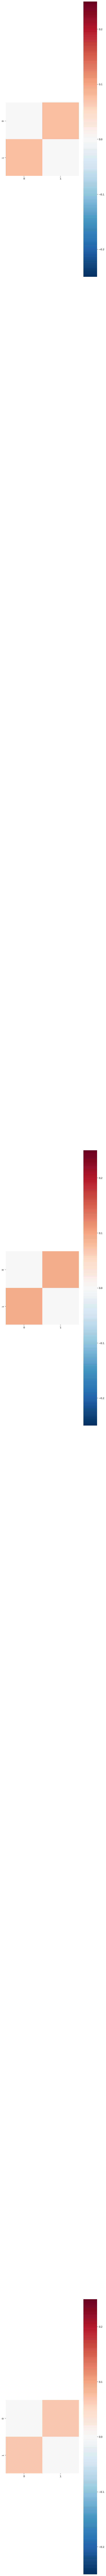

In [375]:
sub_similarity_matrices[sub].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

In [288]:
from tqdm import tqdm
isc_r, isc_p = {}, {}
for roi in tqdm(range(50)):
    sub_r, sub_p = {}, {}
    for sub in subjects:
        story_r, story_p = {}, {} 
        sub_data = {}
        for j, story in enumerate(['run', 'bli', 'dre', 'nei']):
            sub_data['audio'] = ROIs[roi][sub][story]['audio']
            sub_data['visual'] = ROIs[roi][sub][story]['visual']

            #Calculating ISC
            story_stats = isc(pd.DataFrame(sub_data), n_bootstraps=5000, metric='median', method='bootstrap', exclude_self_corr=True)
            story_r[j], story_p[j] = story_stats['isc'], story_stats['p']
        sub_r[sub], sub_p[sub] = story_r, story_p
    isc_r[roi], isc_p[roi] = sub_r, sub_p

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [58:49<00:00, 70.58s/it]
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.co

In [311]:
isc_r[1]

KeyError: 1

In [291]:
pd.DataFrame(sub_data).shape

(117, 2)

# 3. Compute RSA

In [ ]:
isrsa_nn, isrsa_annak = {}, {}
for node in range(len(similarity_matrices)):
    isrsa_nn[node] = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_annak[node] = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=1, n_jobs=1 )['correlation']

isrsa_nn_brain = roi_to_brain(pd.Series(isrsa_nn), expand_mask(mask))
isrsa_annak_brain = roi_to_brain(pd.Series(isrsa_annak), expand_mask(mask))